<a href="https://colab.research.google.com/github/ketanhdoshi/ml/blob/master/lib/arch_lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN MNIST Test App
Notebooks - , 

**Todos**
* Add an assert into ArchBase or somewhere to check that the number of modules after split is the same as the total number of modules in the the model
* Comments for ArchBase
* Reorg CNN MNist as per new App/Arch paradigm
* Change use of DebugYHatCallback so we don't expect it to print anything
* DONE Remove all import nb_xxxx *






### Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#export

import IPython.core.debugger as db
from functools import partial

import torch
from torch import tensor
from torch import nn
from torch.nn import init
from torch import optim
import torch.nn.functional as F

#torch.set_num_threads(2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#export

from nb_util import get_mnist_data, normalize_tr_val, DebugRand
from nb_hooks import Hooks
from nb_data import MultiDimDataset, get_dls
from nb_training import Trainer
from nb_optimiser import get_optimiser

In [ ]:
from nb_util import accuracy
from nb_hooks import StatsHook, plot_stats
from nb_training import CudaCB, MetricsCB
from nb_optimiser import sched_cos, combine_scheds, Recorder, OptimParamCB

### CNN MNIST

The run_cnn_mnist is specific to the CNN Mnist app. But if the data and arch is removed out of that function and passed in, then it becomes a generic end-to-end application runner.

We can then make wrappers or convenience functions for each specific application type which then call that generic end-to-end runner.

The data and architecture for each app type have some dependency on each other. The arch has some fixed params which can be passed during the init. But it also has some data-dependendent params (eg. vocab size, n_classes) which can only be figured out after the data is loaded. See if we can have a generic way to do this by having the data loading also send back a list of "arch parameters", which are then fed to the arch creator function.

Then the last bit of the puzzle are the 'test_*' functions. These allow you to create multiple variations of the end-to-end application by creating and passing in different combinations of data, arch layers, optimisers, callbacks and hooks. See if there is some way to create some convenience functions for these. Otherwise use them the way we are right now - in most cases they are only a few lines of code and not very complicated.

1. data_lib - export the Sampler/Collate/Dataloader
2. DONE training_lib - update annealer to work with optimiser
3. DONE optimiser - simple convenience opt_func for each optimiser
4. arch - finalise design of arch, app, test_* etc

In [ ]:
#export

#----------------------------------------------------
# nn.Module layer that wraps a basic function. This layer is now a regular layer that 
# you can put in nn.Sequential.
#----------------------------------------------------  
class FuncLayer(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [ ]:
#export

#----------------------------------------------------
# Basic functions which we will convert into layers. We will make use of these layers
# in our CNN model
#
# NB: We can't pass in a lambda function into the FuncLayer below, because the model won't pickle and 
# you won't be able to save it with PyTorch. So it's best to use named functions with the FuncLayer.
#----------------------------------------------------
def flatten(x): return x.view(x.shape[0], -1)
# Reshape a flat vector of size (batch_size x 784) into a batch_size of 28x28 images with 1 channel
def mnist_resize(x): return x.view(-1, 1, 28, 28)

#----------------------------------------------------
# Get MNIST train and valid data and prepare the data loaders
# 
# Set the 'repro' flag to allow fetching of data in a known order for reproducibility during debugging
#----------------------------------------------------
def prepare_mnist_data (repro):
  # Load MNIST data and normalise it
  x_train,y_train,x_valid,y_valid = get_mnist_data()
  x_train,x_valid = normalize_tr_val(x_train,x_valid)
  
  # Create Dataset and Data Loader with batch size
  train_ds,valid_ds = MultiDimDataset(x_train, y_train),MultiDimDataset(x_valid, y_valid)
  train_dl,valid_dl = get_dls(train_ds, valid_ds, bs=512, repro=repro)
  
  # Number of output classes
  n_classes = y_train.max().item()+1

  return (train_dl, valid_dl, n_classes)

#----------------------------------------------------
# Create a CNN architecture with a series of paired Conv2D and Relu layers. Each Relu layer is optionally
# followed by a BatchNorm layer. In other words, the last layer of each Conv set can be either a 
# Relu or a BatchNorm. In addition, before and after these Conv sets, there are some
# pre and post layers that reshape the data as needed.
#
# We are given some optional parameters:
#    a list of output filter sizes for each Conv layer
#    a relu creation function which we use to create the Relu layer instead of the built-in Relu function
#    a batch norm creation function we use to create a BatchNorm layer
#    an initialisation function for the Conv layer weights and biases
#
# We have a flag to allow reproducibility of results for debugging. This uses the DebugRand class to
# set the Random Number Generator to a known state before initialising any layer weights/biases
#
# To use this class, first initialise it with all the necessary parameters, and then call() it.
#     arch = CNNArch(...)
#     model, hook_layers = arch(n_classes)
#
# We also return a tuple of two lists of layers ie. ([list of all model layers], [list of last layer in each Conv set])
#----------------------------------------------------
class CNNArch():
  def __init__(self, filter_list=None, relu_fn=None, bn_fn=None, init_conv_fn=None):
    # eg. with mnist 28x28 images, these 4 conv layers will output images of size
    # 14x14, 7x7, 4x4 and 2x2 respectively
    default_filters = [8, 16, 32, 64]

    self.filter_list=filter_list if filter_list is not None else default_filters
    self.relu_fn, self.bn_fn, self.init_conv_fn = relu_fn, bn_fn, init_conv_fn

  # ----------------------------
  # Creates the architecture based on the parameters provided during initialisation
  # ----------------------------
  def __call__(self, n_classes, repro=False):
    # For reproducibility during debugging 
    DebugRand.repro = repro

    # Number of conv layers
    filter_list=self.filter_list
    num_conv_layers = len(filter_list)
    
    # We prepare two lists - a list of Conv + Relu + BatchNorm layer sets, and
    # a list of the last layer of each set
    conv_layers = []
    end_layers = []
    for i in range(num_conv_layers):
      
      # The first layer always has 1 input filter. All subsequent layers have the same number of input filters
      # as the number of output filters of the previous layer. The first layer also has a different kernel size
      # than all subsequent layers
      if (i == 0):
        num_inp_filters = 1
        kernel_size = 5
      else:
        num_inp_filters = filter_list[i - 1]
        kernel_size = 3

      # Create a set consisting of a Conv layer, a Relu layer and an optional BatchNorm layer.
      # All these layers are added to the list of layers

      # The Conv layer has no bias if we are using BatchNorm
      bias = True if self.bn_fn is None else False
      conv = nn.Conv2d (num_inp_filters, filter_list[i], kernel_size, padding=kernel_size//2, stride=2, bias=bias)
      relu = nn.ReLU() if self.relu_fn is None else self.relu_fn()
      conv_layers.extend([conv, relu])

      # Create a BatchNorm layer if a creation function is provided
      if (self.bn_fn is not None):
        conv_layers.append (self.bn_fn(filter_list[i]))

      # Add the last layer in the set
      end_layers.append(conv_layers[-1])

      # Initialise the weights (and biases) of the Conv layer
      if (self.init_conv_fn):
        DebugRand.set_seed(555)                   # Set RNG to a known state
        self.init_conv_fn(conv)
        DebugRand.show_state(conv.weight.shape, conv.weight.mean())
      
    # Create the architecture. We have a pre-layer that reshapes the flat MNIST input from 784 to 28x28 images
    # and some post layers for classification.
    DebugRand.set_seed(555)                       # Set RNG to a known state
    lin = nn.Linear(filter_list[-1], n_classes)
    DebugRand.show_state(lin.weight.shape, lin.weight.mean())
    final_layers = [nn.AdaptiveAvgPool2d(1), FuncLayer(flatten), lin]
    arch = nn.Sequential(
        FuncLayer(mnist_resize),
        *conv_layers,
        *final_layers
    )
    
    return (arch, (conv_layers + final_layers, end_layers))

#----------------------------------------------------
# Run a full MNIST CNN model end-to-end
#
# We have a lot of flexibility to run this:
#    With different CNN architectures by passing in an architecture creation function
#    With different optimisers by passing in an optimiser function
#    We can provide callbacks and hooks to be attached
#----------------------------------------------------
def run_cnn_mnist(num_epochs, arch_fn, opt_func=optim.SGD, opt_groups=None, lr=0.4, cbs=[], hook_cls=None, repro=False):
  # Prepare the data
  train_dl, valid_dl, n_classes = prepare_mnist_data (repro)

  # Create the CNN architecture
  arch, hook_layers = arch_fn(n_classes, repro)

  # Loss Function
  loss_func = F.cross_entropy

  # Optimiser
  opt = get_optimiser(arch, lr, opt_func, opt_groups)

  # Create the training loop and run it for the given number of epochs
  loop = Trainer(train_dl, valid_dl, arch, opt, loss_func, cbs)
  
  # If a list of hook classes has been provided, add those hooks to the model layers
  if (hook_cls):
    # Add hooks to the hook_layers and save a list of all the hooks
    loop.hooks = Hooks(hook_layers, hook_cls)
  
  # Run the training loop
  loop.fit(num_epochs)

  return(loop)

In [ ]:
# Run without GPU and measure timings
lr_cbs = [Recorder(), MetricsCB({"acc": accuracy})]
%time run_cnn_mnist(1, CNNArch(), cbs=lr_cbs, repro=True)
print ('----------')

# Run with GPU and measure timings
lr_gpu_cbs = [Recorder(), MetricsCB({"acc": accuracy}), CudaCB(device = torch.device('cuda',0))]
%time run_cnn_mnist(1, CNNArch(), cbs=lr_gpu_cbs, repro=True)
print ('----------')

# Print out the layers of the model
arch=CNNArch(filter_list=[8, 16, 32, 32])
arch(10)

RNG State tensor(63.4610) tensor(63.3932) torch.Size([10, 64]) tensor(-0.0022, grad_fn=<MeanBackward0>)
['epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'time']
['0', '1.879935', '0.357634', '0.850320', '0.695316', '00:04']
CPU times: user 4.87 s, sys: 431 ms, total: 5.3 s
Wall time: 9.2 s


----------
RNG State tensor(62.8354) tensor(63.3932) torch.Size([10, 64]) tensor(-0.0022, grad_fn=<MeanBackward0>)
['epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'time']
['0', '1.771844', '0.400672', '0.433041', '0.866059', '00:01']
CPU times: user 4.72 s, sys: 1.26 s, total: 5.99 s
Wall time: 12.6 s


----------


(Sequential(
   (0): FuncLayer()
   (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (2): ReLU()
   (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (4): ReLU()
   (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (6): ReLU()
   (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (8): ReLU()
   (9): AdaptiveAvgPool2d(output_size=1)
   (10): FuncLayer()
   (11): Linear(in_features=32, out_features=10, bias=True)
 ),
 ([Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
   ReLU(),
   Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
   ReLU(),
   Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
   ReLU(),
   Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
   ReLU(),
   AdaptiveAvgPool2d(output_size=1),
   FuncLayer(),
   Linear(in_features=32, out_features=10, bias=True)],
  [ReLU(), ReLU(), ReLU(), ReLU()]))

### Test with Param Scheduler and Recorder

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
lr_cbs = [CudaCB(device = torch.device('cuda',0)), Recorder(), MetricsCB({"acc": accuracy}), OptimParamCB("lr", sched)]
loop = run_cnn_mnist(1, CNNArch(), cbs=lr_cbs, repro=True)
loop.cbs[1].plot_loss()

RNG State tensor(63.7391) tensor(63.3932) torch.Size([10, 64]) tensor(-0.0022, grad_fn=<MeanBackward0>)
['epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'time']
['0', '1.729809', '0.378768', '0.536117', '0.832731', '00:00']


NameError: ignored

In [ ]:
loop.cbs[1].plot_lr()

### Test with Hooks

RNG State tensor(62.8354) tensor(63.3932) torch.Size([10, 64]) tensor(-0.0022, grad_fn=<MeanBackward0>)


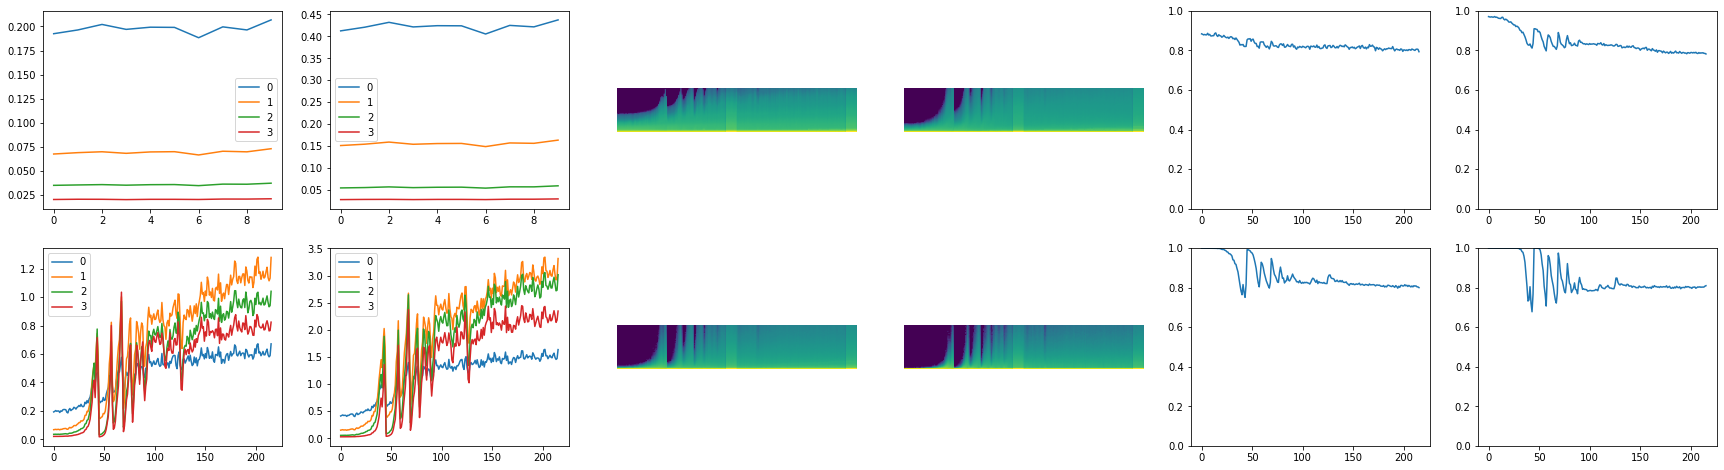

In [ ]:
def test_hook():
  loop = run_cnn_mnist(2, CNNArch(), cbs=[], hook_cls=([],[StatsHook]), repro=True)
  plot_stats (loop.hooks)

test_hook()

### Kaiming Init

In [ ]:
#export

#----------------------------------------------------
# Initialise the weights and bias of a Conv layer using either Kaiming Normal
# or Kaiming Uniform.
#
# To use it:
#    init_fn = InitConv(..)
#    init_fn(conv_layer)
#----------------------------------------------------
class InitConv():
  def __init__(self, type, a=None):
    # 'Type' is either 'uniform' or 'normal'
    self.type=type
    # 'a' is an initialisation parameter used by the Kaiming function
    self.a=a

  # ----------------------------
  # Initialise the weights and biases
  # ----------------------------
  def __call__(self, conv):
    # Select the initialisation function
    if (self.type == "uniform"):
      init_fn = init.kaiming_uniform_
    elif (self.type == "normal"):
      init_fn = init.kaiming_normal_

    # Set the weights using the 'a' parameter if one is given
    if (self.a is None):
       init_fn(conv.weight)
    else:
      init_fn(conv.weight, a=self.a)
    
    # Initialise the bias if the conv layer has biases
    if getattr(conv, 'bias', None) is not None:
      conv.bias.data.zero_()

RNG State tensor(63.4436) tensor(62.5870) torch.Size([8, 1, 5, 5]) tensor(-0.0113, grad_fn=<MeanBackward0>)
RNG State tensor(63.5162) tensor(63.3932) torch.Size([16, 8, 3, 3]) tensor(-0.0038, grad_fn=<MeanBackward0>)
RNG State tensor(62.4308) tensor(63.2371) torch.Size([32, 16, 3, 3]) tensor(-0.0021, grad_fn=<MeanBackward0>)
RNG State tensor(62.0653) tensor(62.9187) torch.Size([64, 32, 3, 3]) tensor(-0.0003, grad_fn=<MeanBackward0>)
RNG State tensor(62.9187) tensor(63.3932) torch.Size([10, 64]) tensor(-0.0022, grad_fn=<MeanBackward0>)


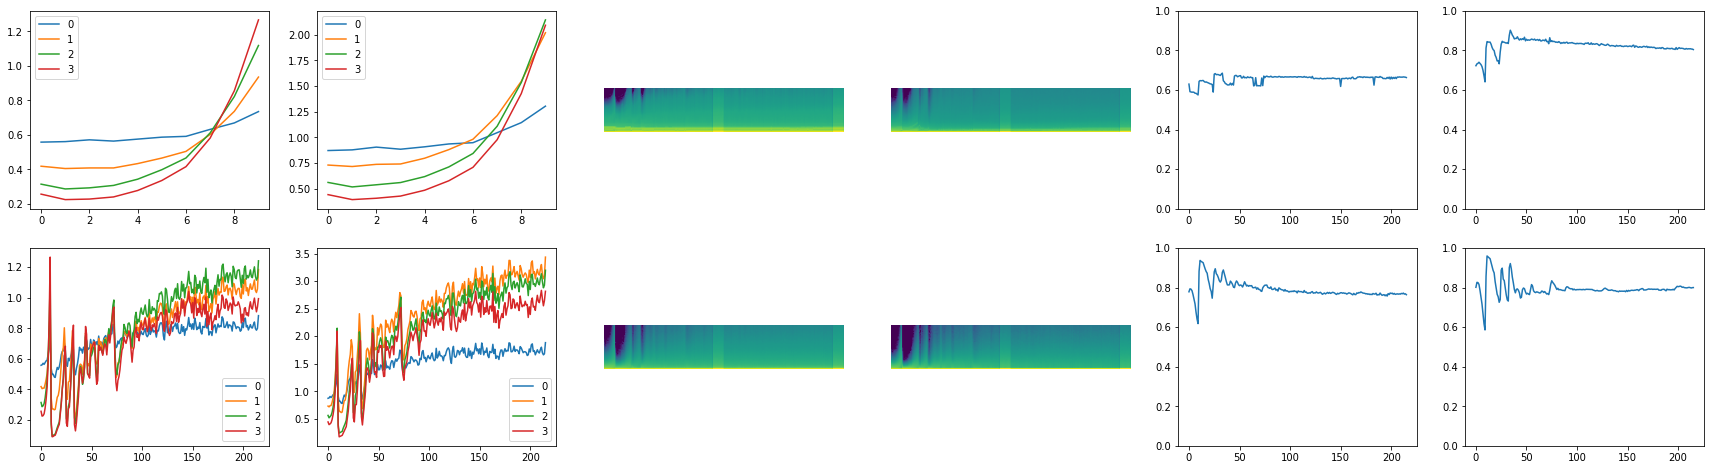

In [ ]:
# Plot statistics using Kaiming initialisation
def test_hook_kaiming():
  init_conv_fn=InitConv("normal")
  loop = run_cnn_mnist(2, CNNArch(init_conv_fn=init_conv_fn), cbs=[], hook_cls=([],[StatsHook]), repro=True)
  plot_stats (loop.hooks)
  
test_hook_kaiming()

### Use Generalised ReLU instead of Pytorch built-in Relu

In [ ]:
#export

#----------------------------------------------------
# Generalised Relu module which can:
# Leaky - use a leaky Relu instead of a regular Relu
# Subtract - subtract a fixed value from the calculated Relu value
# Max - Force a max value for the Relu value
#----------------------------------------------------
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

### Test General Relu - NB: Redefined get_min is not getting applied

RNG State tensor(63.4436) tensor(62.5870) torch.Size([8, 1, 5, 5]) tensor(-0.0112, grad_fn=<MeanBackward0>)
RNG State tensor(63.5162) tensor(63.3932) torch.Size([16, 8, 3, 3]) tensor(-0.0038, grad_fn=<MeanBackward0>)
RNG State tensor(62.4308) tensor(63.2371) torch.Size([32, 16, 3, 3]) tensor(-0.0020, grad_fn=<MeanBackward0>)
RNG State tensor(63.6394) tensor(62.8625) torch.Size([32, 32, 3, 3]) tensor(-0.0005, grad_fn=<MeanBackward0>)
RNG State tensor(62.8625) tensor(62.5366) torch.Size([10, 32]) tensor(0.0042, grad_fn=<MeanBackward0>)


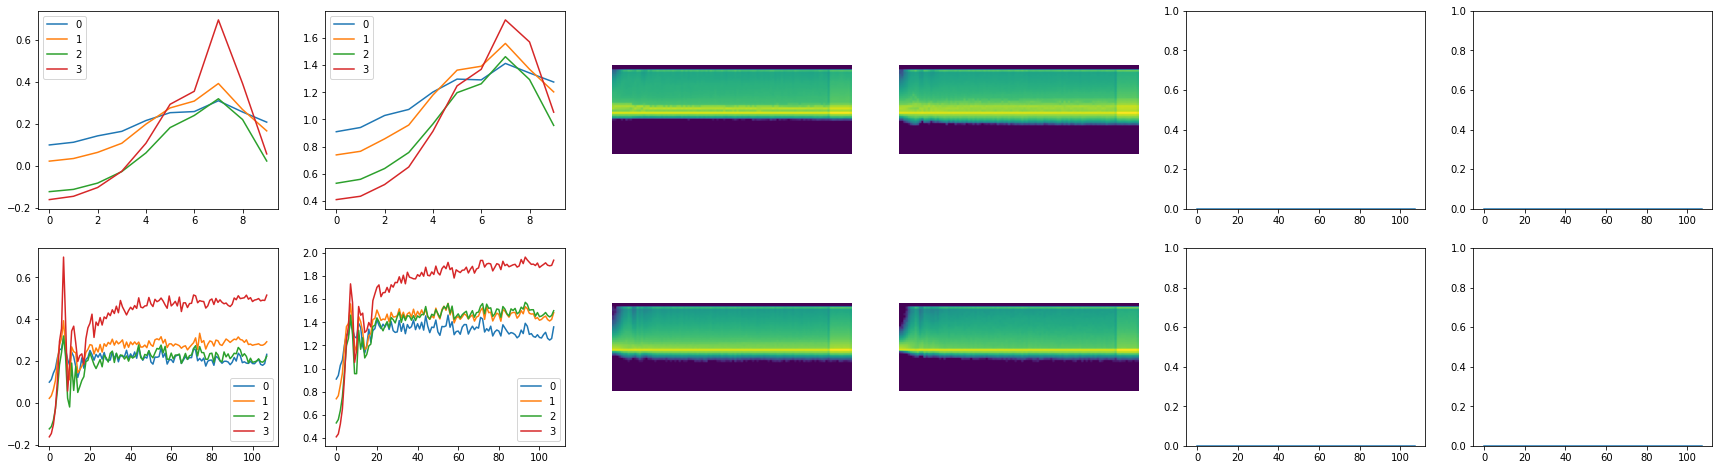

In [ ]:
#----------------------------------------------------
# Redefine the previously defined function to get the min histogram values so we can zoom in
#----------------------------------------------------
def get_min(hists):
    h1 = torch.stack(hists).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

# Plot statistics using Kaiming initialisation
def test_hook_genrelu_kaiming():
  StatsHook.histc_min, StatsHook.histc_max = -7, 7
  init_conv_fn=InitConv("normal", a=0.1)
  relu_fn=partial(GeneralRelu, leak=0.1, sub=0.4, maxv=6.)
  #hook_cls=([partial(DebugActivationHook, do_print=True)],[StatsHook])
  hook_cls=([],[StatsHook])
  loop = run_cnn_mnist(1, CNNArch(filter_list=[8, 16, 32, 32], relu_fn=relu_fn, init_conv_fn=init_conv_fn), cbs=[], lr=0.9, hook_cls=hook_cls, repro=True)
  plot_stats (loop.hooks)
  
test_hook_genrelu_kaiming()

### Add a Batch Norm Layer

In [ ]:
#export

class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        #print('BN', m.mean(), v.mean(), x.mean())
        return x*self.mults + self.adds

RNG State tensor(62.5366) tensor(62.5870) torch.Size([8, 1, 5, 5]) tensor(-0.0112, grad_fn=<MeanBackward0>)
RNG State tensor(63.5162) tensor(63.3932) torch.Size([16, 8, 3, 3]) tensor(-0.0038, grad_fn=<MeanBackward0>)
RNG State tensor(62.4308) tensor(63.2371) torch.Size([32, 16, 3, 3]) tensor(-0.0020, grad_fn=<MeanBackward0>)
RNG State tensor(62.9229) tensor(62.9187) torch.Size([64, 32, 3, 3]) tensor(-0.0003, grad_fn=<MeanBackward0>)
RNG State tensor(62.9187) tensor(63.3932) torch.Size([10, 64]) tensor(-0.0022, grad_fn=<MeanBackward0>)


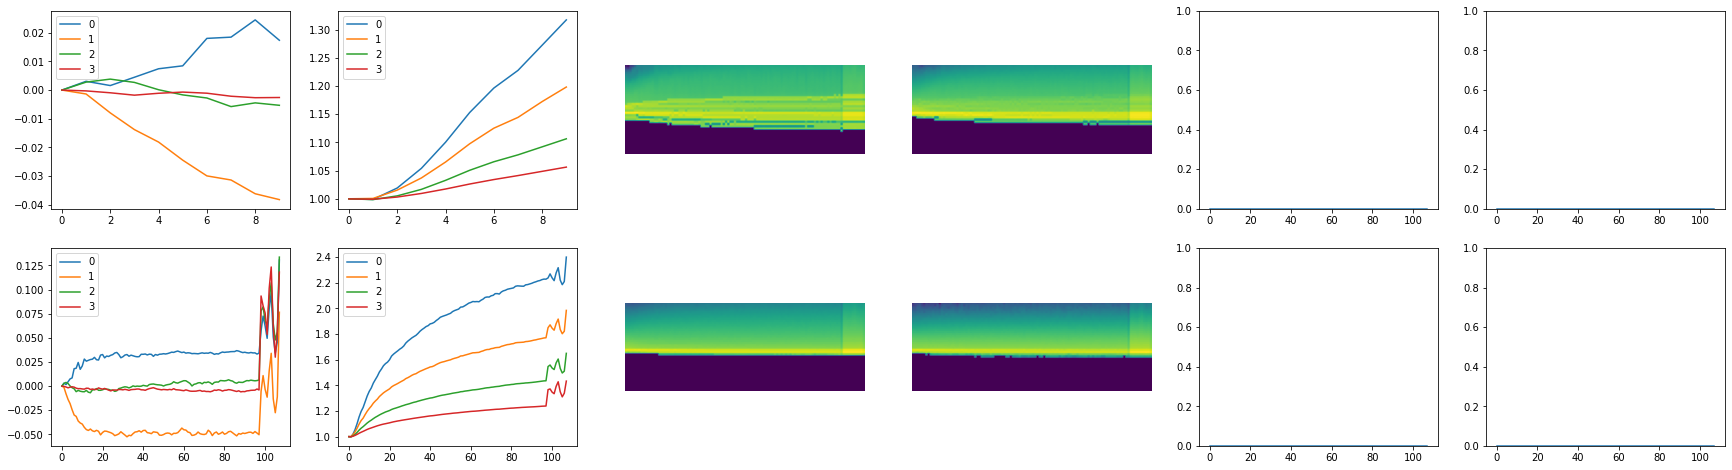

In [ ]:
def test_hook_batchnorm():
  StatsHook.histc_min, StatsHook.histc_max = -7, 7
  #gpu_cbs = [DebugYhatLossCB(), CudaCB(device = torch.device('cuda',0))]
  gpu_cbs = [CudaCB(device = torch.device('cuda',0))]
  #hook_cls=([partial(DebugActivationHook, do_print=True), partial(DebugGradHook, do_print=False)], [StatsHook])
  hook_cls=([], [StatsHook])
  arch=CNNArch(relu_fn=GeneralRelu, bn_fn=BatchNorm, init_conv_fn=InitConv("normal", a=0.1))
  loop = run_cnn_mnist(1, arch, cbs=gpu_cbs, lr=0.9, hook_cls=hook_cls, repro=True)
  plot_stats (loop.hooks)

test_hook_batchnorm()

### Arch Base

In [ ]:
# The len() checks below should be put into an assert to make sure that all modules are
# included when splitting

def mod_gr ():
  mgs = is_app._arch.module_groups()
  mgs = [nn.Sequential(mg) for mg in mgs]
  len(list(mgs[0].modules())) + len(list(mgs[1].modules())) + len(list(mgs[2].modules())), len (list(is_app._arch.model.modules()))
  len(list(mgs[0].parameters())) + len(list(mgs[1].parameters())) + len(list(mgs[2].parameters())), len (list(is_app._arch.model.parameters()))

In [ ]:
#export

class ArchBase:
  def __init__(self):
    self.model = None

  # ----------------------------
  # Show summary of the model with output sizes of each layer, for a given
  # input size
  # ----------------------------
  def summary(self, input_sz):
    from torchsummary import summary
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = self.model.to(device)
    summary(model, input_size=input_sz)

  # ----------------------------
  # Load previously saved model weights
  # ----------------------------
  def load_weights(self, weights_path):
    weights = torch.load(weights_path)
    self.model.load_state_dict(weights)

  # ----------------------------
  # Save the model weights (after training)
  # ----------------------------
  def save_weights(self, weights_path):
    # Save the full model
    torch.save(self.model.state_dict(), weights_path)

  # ----------------------------
  # Freeze some layers of the model
  # ----------------------------
  def freeze(self, module=None, on=False):
    module = module if module is not None else self.model
    rg = not on

    # Get learnable parameters of all sub-modules in 'module'
    for m in module.modules():
      # We always leave BatchNorm layers unfrozen, so we never touch
      # them while freezing or unfreezing
      if not isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        for p in m.parameters():
          p.requires_grad_(rg)

  # ----------------------------
  # Define the module-layer groups to split the model for discriminative LRs. 
  # The parameters from each module group will be put into separate parameter 
  # groups.
  # ----------------------------
  def module_groups(self):
    lr_groups = [self.model]
    return lr_groups

  # ----------------------------
  # Create the model
  # ----------------------------
  def create_model(self):
    pass

### Export

In [ ]:
!wget https://raw.githubusercontent.com/ketanhdoshi/ml/master/lib/nb_export.py

--2020-05-07 07:30:33--  https://raw.githubusercontent.com/ketanhdoshi/ml/master/lib/nb_export.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477 (1.4K) [text/plain]
Saving to: ‘nb_export.py’

nb_export.py        100%[===================>]   1.44K  --.-KB/s    in 0s      

2020-05-07 07:30:33 (25.1 MB/s) - ‘nb_export.py’ saved [1477/1477]



In [ ]:
from nb_export import notebook2scriptSingle
notebook2scriptSingle(gn_path + '/lib/arch_lib.ipynb', gn_path + '/exp')

Converted gdrive/My Drive/Colab Notebooks/lib/arch_lib.ipynb to gdrive/My Drive/Colab Notebooks/exp/nb_arch.py
